In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 导入数据

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# Load data
path = "/kaggle/input/ace-dataset/auto-enconder-features/"
data_ = pd.read_csv(path + 'AEDN-50.csv', header= None)
data = data_.iloc[:, :-1].values
# labels = data_.iloc[:, -1].values

label1=np.ones((394,1))#Value can be changed
label2=np.zeros((626,1))
labels=np.append(label1,label2)

y = labels
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y.shape)
print(np.count_nonzero(y==0))
print(np.count_nonzero(y==1))


In [ ]:
import os
import statistics
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from keras.layers import Input, Dense
from keras.layers import BatchNormalization, LeakyReLU, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, roc_curve, auc, average_precision_score, precision_recall_curve, f1_score,accuracy_score
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split

# 
# Load data
path = "/kaggle/input/ace-dataset/auto-enconder-features/"
data_ = pd.read_csv(path + 'AEDN-50.csv', header= None)
data = data_.iloc[:, :-1].values
# labels = data_.iloc[:, -1].values

label1=np.ones((394,1))#Value can be changed
label2=np.zeros((626,1))
labels=np.append(label1,label2)

# y = labels
# X = data

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

X = X_train
y = y_train

[sample_num, input_dimwx] = np.shape(X)
out_dim = 2

optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Discriminator
D = Sequential()
D.add(Dense(64, input_dim=input_dimwx))
D.add(LeakyReLU(alpha=0.2))
D.add(Dropout(0.3))
D.add(Dense(32))
D.add(LeakyReLU(alpha=0.2))
D.add(Dense(out_dim, activation='sigmoid'))
img = Input(shape=(input_dimwx,))
validity = D(img)
Discriminator = Model(img, validity)
Discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

# Generator
G = Sequential()
G.add(Dense(64, input_dim=input_dimwx))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(64))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(32))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(input_dimwx, activation='tanh'))
noise = Input(shape=(input_dimwx,))
G_img = G(noise)
Generator = Model(noise, G_img)

z = Input(shape=(input_dimwx,))
G_img = Generator(z)
Discriminator.trainable = False
validity = Discriminator(G_img)
GAN = Model(z, validity)
GAN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

# Initialize metric collections
accuracy_collecton = []
BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
AUC_collecton = []
F1_collecton = []
AP = []

mean_recall = np.linspace(0, 1, 100)
all_precision = []
base_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0

interp_tpr_collection = []

def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)

def to_categorical(y, nb_classes=None):
    y = np.array(y, dtype='int')
    if not nb_classes:
        nb_classes = np.max(y) + 1
    Y = np.zeros((len(y), nb_classes))
    for i in range(len(y)):
        Y[i, y[i]] = 1
    return Y

outpath = '/kaggle/working/'
skf = StratifiedKFold(n_splits=10)

fold_num = 1
for train, test in skf.split(X, y):
    X_train, X_valid = np.take(X, train.tolist(), axis=0), np.take(X, test.tolist(), axis=0)
    y_train, y_valid = np.take(y, train.tolist(), axis=0), np.take(y, test.tolist(), axis=0)

    y_train = to_categorical(y_train)

    clf = GAN

    # Define callbacks
    model_path = outpath + f'GAN/GAN_fold_{fold_num}.h5'
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
        ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
    ]

    hist = clf.fit(X_train, y_train, batch_size=64, epochs=60, validation_data=(X_valid, to_categorical(y_valid)), callbacks=callbacks)

    # Load the best model
    clf.load_weights(model_path)

    y_score = clf.predict(X_valid)
    y_class = categorical_probas_to_classes(y_score)

    TP, FP, FN, TN = confusion_matrix(y_valid, y_class).ravel()
    Sn_collecton.append(TP / (TP + FN))
    Sp_collecton.append(TN / (TN + FP))
    MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5 * TP / (TP + FN) + 0.5 * TN / (TN + FP))

    # Calculate Accuracy
    accuracy = accuracy_score(y_valid, y_class)
    accuracy_collecton.append(accuracy)
    # Calculate F1-score
    f1 = f1_score(y_valid, y_class)
    F1_collecton.append(f1)

    fpr, tpr, _ = roc_curve(y_valid, y_score[:, 1])
    interp_tpr = np.interp(base_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tpr_collection.append(interp_tpr)
    auc_roc = auc(fpr, tpr)
    AUC_collecton.append(auc_roc)

    precision, recall, _ = precision_recall_curve(y_valid, y_score[:, 1])
    average_precision = average_precision_score(y_valid, y_score[:, 1])
    recall = np.flipud(recall)
    precision = np.flipud(precision)
    mean_precision = np.interp(mean_recall, recall, precision)
    all_precision.append(mean_precision)
    AP.append(average_precision)

    fold_num += 1
print(f"Accuracy: {round(statistics.mean(accuracy_collecton), 3)} ± {round(statistics.stdev(accuracy_collecton), 3)}")
print(f"BACC: {round(statistics.mean(BACC_collecton), 3)} ± {round(statistics.stdev(BACC_collecton), 3)}")
print(f"Sn: {round(statistics.mean(Sn_collecton), 3)} ± {round(statistics.stdev(Sn_collecton), 3)}")
print(f"Sp: {round(statistics.mean(Sp_collecton), 3)} ± {round(statistics.stdev(Sp_collecton), 3)}")
print(f"MCC: {round(statistics.mean(MCC_collecton), 3)} ± {round(statistics.stdev(MCC_collecton), 3)}")
print(f"F1: {round(statistics.mean(F1_collecton), 3)} ± {round(statistics.stdev(F1_collecton), 3)}")
print(f"AUC: {round(statistics.mean(AUC_collecton), 3)} ± {round(statistics.stdev(AUC_collecton), 3)}")
print(f"AP: {round(statistics.mean(AP), 3)} ± {round(statistics.stdev(AP), 3)}")

mean_tpr = np.mean(interp_tpr_collection, axis=0)
mean_tpr[-1] = 1.0

mean_precision = np.mean(all_precision, axis=0)

np.savez(outpath+'GAN/ROC_curve\GAN_PCA_All_cross_vaild.npz', fpr=base_fpr, tpr=mean_tpr, roc_auc=AUC_collecton)
np.savez(outpath+'GAN/PR_curve\GAN_PCA_All_cross_vaild.npz', recall=mean_recall, precision=mean_precision, average_precision=AP)

plt.figure()
lw = 2
plt.plot(base_fpr, mean_tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % np.mean(AUC_collecton))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('10 k-fold cross valid')
plt.legend(loc="lower right")
plt.show()


12/12 [==============================] - 0s 3ms/step

Model 1:

Accuracy: 0.871

BACC: 0.861

Sn: 0.833

Sp: 0.889

MCC: 0.713

AUC: 0.93

AP: 0.946

F1: 0.902




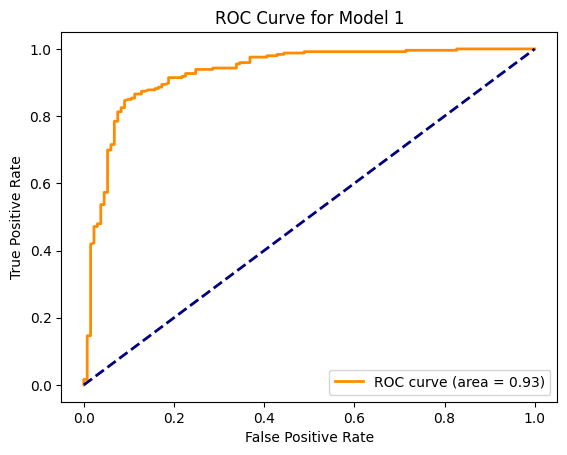

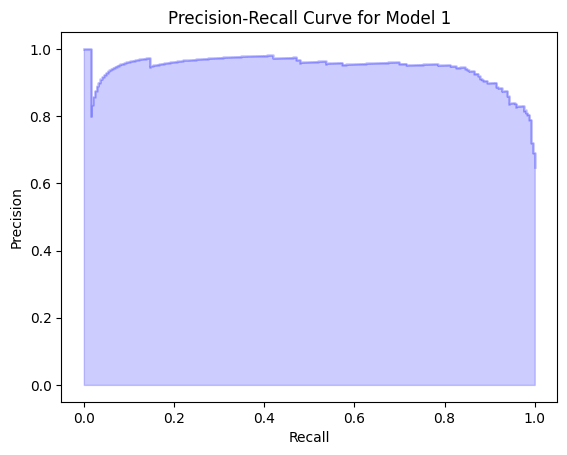

12/12 [==============================] - 0s 2ms/step

Model 2:

Accuracy: 0.884

BACC: 0.887

Sn: 0.894

Sp: 0.88

MCC: 0.741

AUC: 0.93

AP: 0.938

F1: 0.914




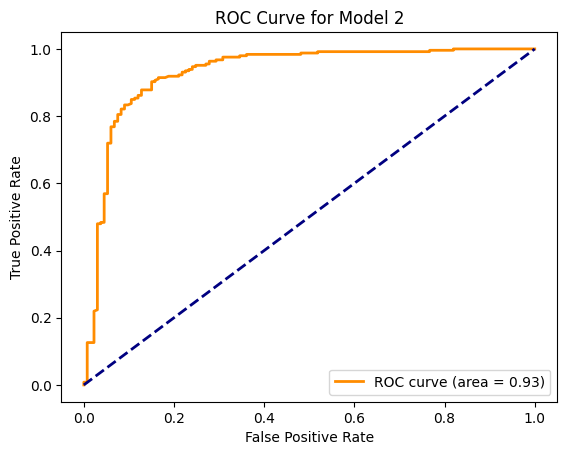

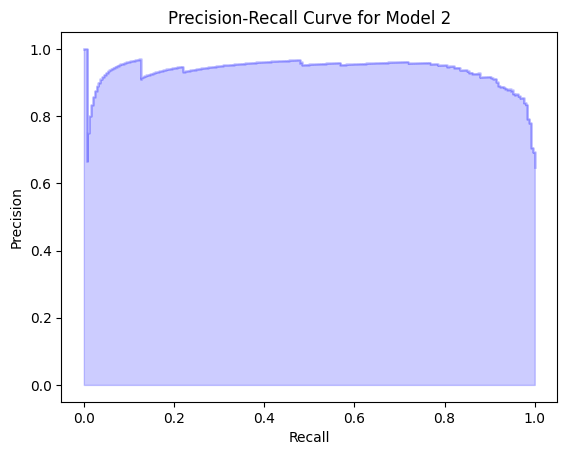

12/12 [==============================] - 0s 3ms/step

Model 3:

Accuracy: 0.865

BACC: 0.862

Sn: 0.853

Sp: 0.871

MCC: 0.699

AUC: 0.923

AP: 0.937

F1: 0.9




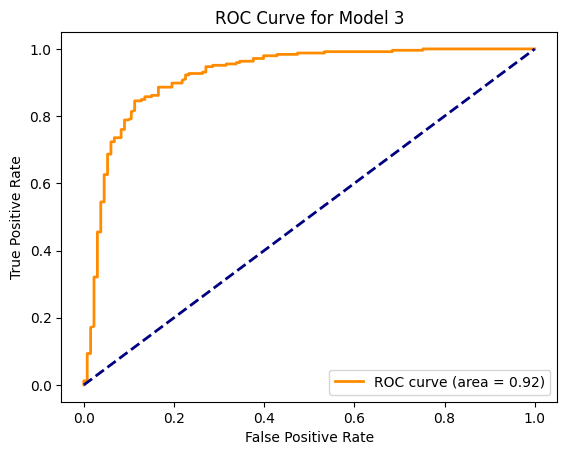

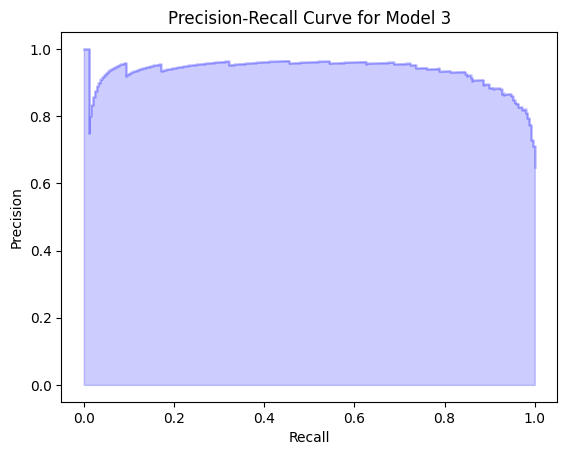

12/12 [==============================] - 0s 3ms/step

Model 4:

Accuracy: 0.881

BACC: 0.877

Sn: 0.867

Sp: 0.888

MCC: 0.736

AUC: 0.927

AP: 0.94

F1: 0.911




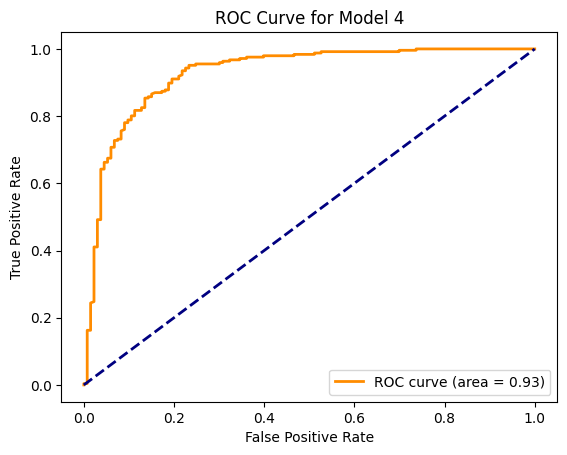

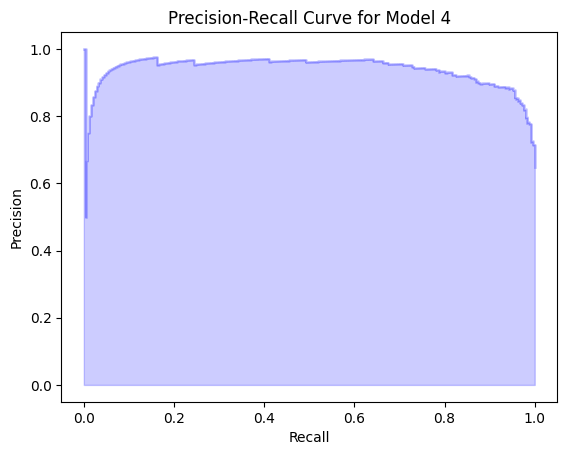

12/12 [==============================] - 0s 3ms/step

Model 5:

Accuracy: 0.876

BACC: 0.87

Sn: 0.852

Sp: 0.887

MCC: 0.724

AUC: 0.93

AP: 0.938

F1: 0.907




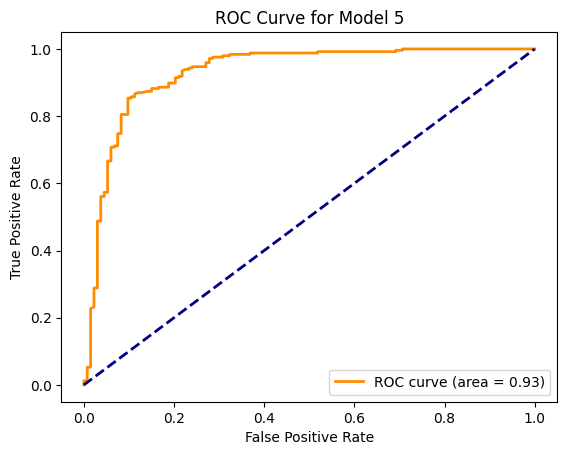

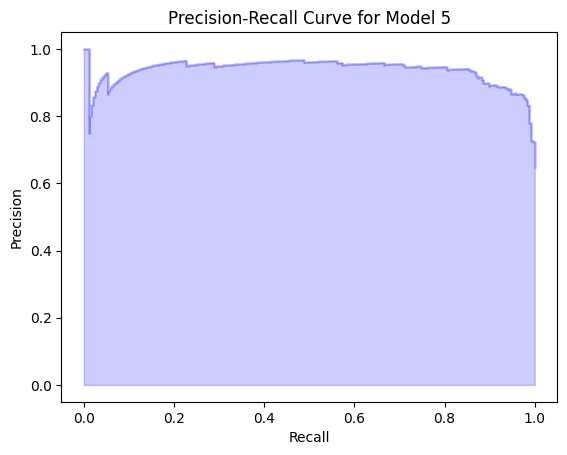

12/12 [==============================] - 0s 3ms/step

Model 6:

Accuracy: 0.871

BACC: 0.864

Sn: 0.844

Sp: 0.883

MCC: 0.712

AUC: 0.921

AP: 0.927

F1: 0.903




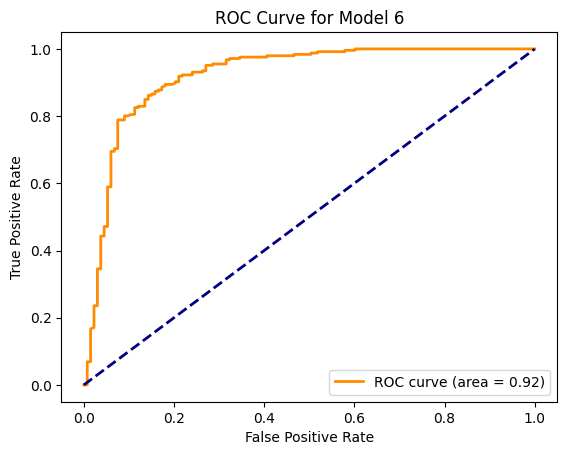

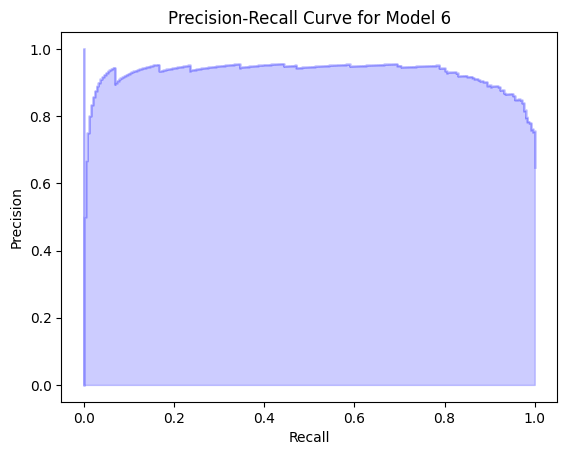

12/12 [==============================] - 0s 4ms/step

Model 7:

Accuracy: 0.865

BACC: 0.854

Sn: 0.82

Sp: 0.888

MCC: 0.702

AUC: 0.926

AP: 0.938

F1: 0.897




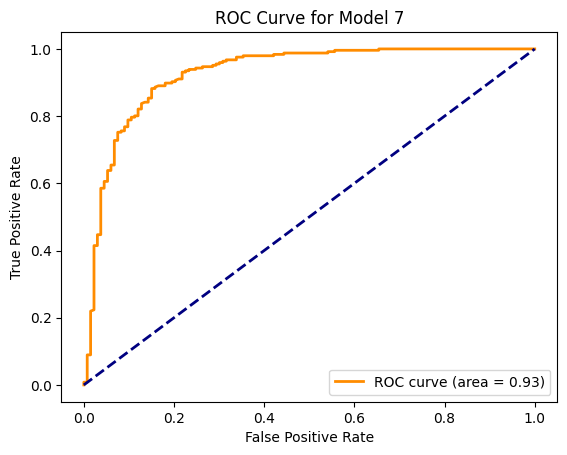

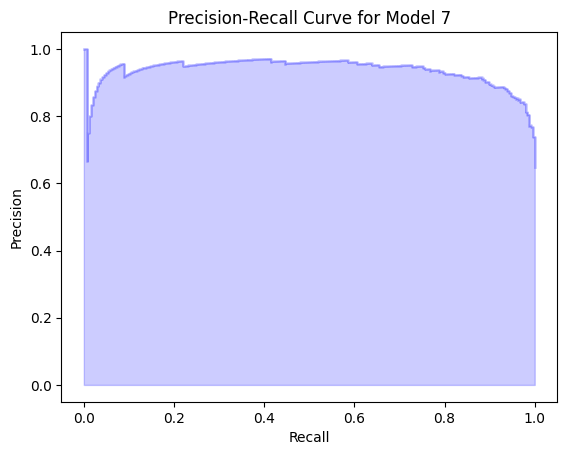

12/12 [==============================] - 0s 4ms/step

Model 8:

Accuracy: 0.879

BACC: 0.875

Sn: 0.866

Sp: 0.885

MCC: 0.729

AUC: 0.934

AP: 0.943

F1: 0.909




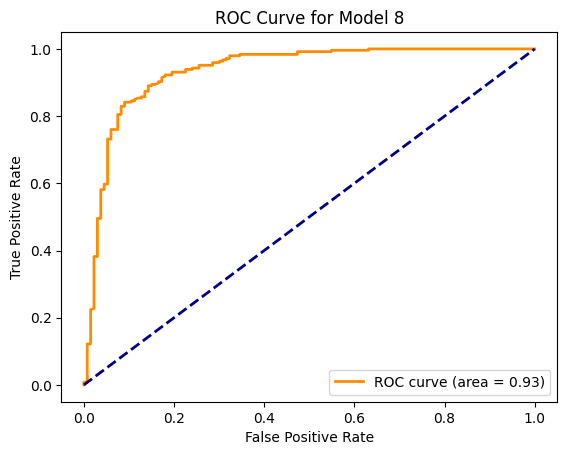

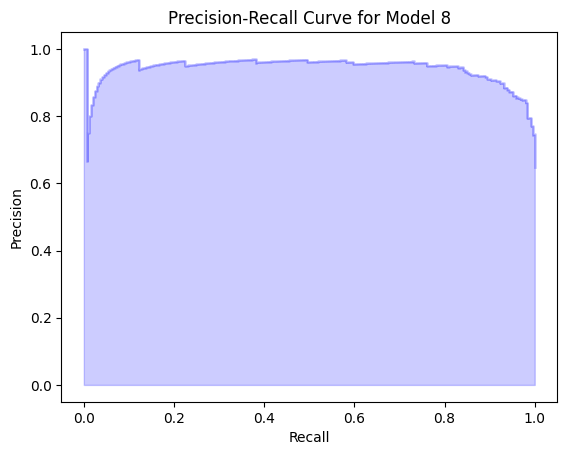

12/12 [==============================] - 0s 3ms/step

Model 9:

Accuracy: 0.881

BACC: 0.879

Sn: 0.873

Sp: 0.885

MCC: 0.735

AUC: 0.931

AP: 0.941

F1: 0.911




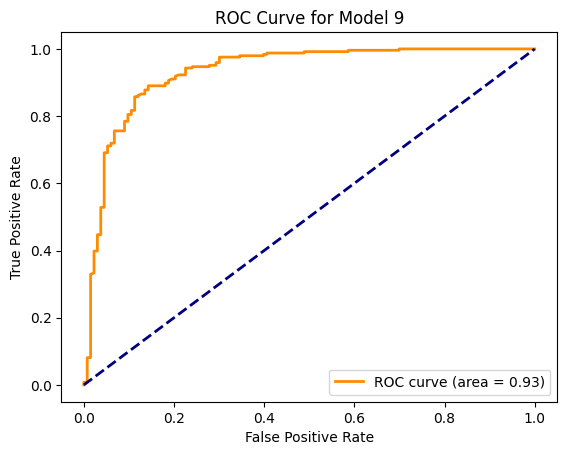

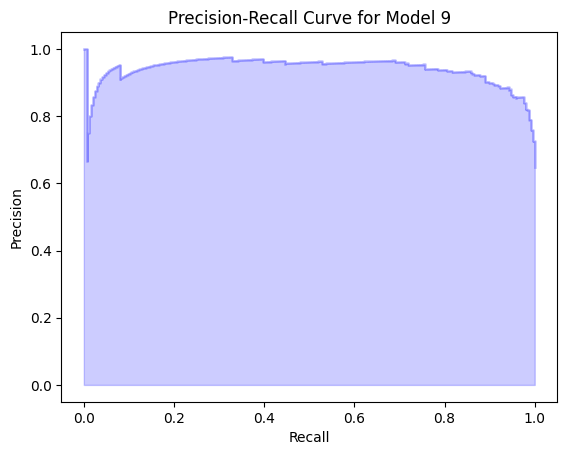

12/12 [==============================] - 0s 3ms/step

Model 10:

Accuracy: 0.868

BACC: 0.864

Sn: 0.855

Sp: 0.874

MCC: 0.705

AUC: 0.924

AP: 0.933

F1: 0.902




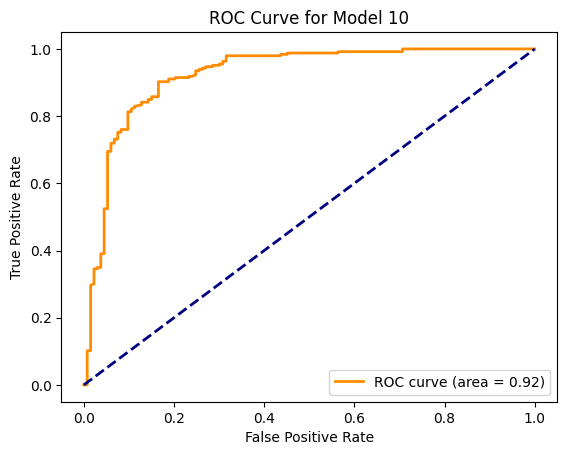

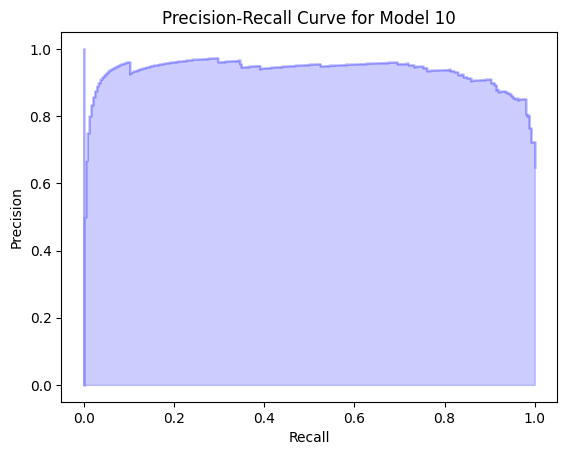

Average Accuracy: 0.874 ± 0.007

Average BACC: 0.869 ± 0.009

Average Sn: 0.856 ± 0.02

Average Sp: 0.883 ± 0.006

Average MCC: 0.72 ± 0.014

Average AUC: 0.928 ± 0.004

Average AP: 0.938 ± 0.005

Average F1: 0.905 ± 0.005


In [11]:
from keras.models import load_model
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, roc_curve, auc, average_precision_score, precision_recall_curve, f1_score, accuracy_score
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# path = "/content/drive/MyDrive/watshara_data/"
# data_ = pd.read_csv(path + 'Dts_AEDN1000.csv')
# data = data_.iloc[:, :-1].values
# labels = data_.iloc[:, -1].values
# y = labels
# Xt = scale(data)
# yt = labels

X = X_test
y = y_test
# Initialize lists to store metrics for each model
accuracies = []
BACCs = []
Sns = []
Sps = []
MCCs = []
AUCs = []
APs = []
F1s = []

# Iterate through each model and evaluate
for fold_num in range(1, 11):  # Assuming models are saved as GAN_fold_1.h5, GAN_fold_2.h5, ..., GAN_fold_10.h5
    model_path = path + f'GAN/GAN_fold_{fold_num}.h5'
    clf = load_model(model_path)

    # Predict the labels for the independent dataset
    y_score = clf.predict(Xt)
    y_class = np.argmax(y_score, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(yt, y_class)
    accuracies.append(accuracy)

    TP, FP, FN, TN = confusion_matrix(yt, y_class).ravel()
    Sn = TP / (TP + FN)
    Sns.append(Sn)
    Sp = TN / (TN + FP)
    Sps.append(Sp)
    MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    MCCs.append(MCC)
    BACC = 0.5 * Sn + 0.5 * Sp
    BACCs.append(BACC)

    fpr, tpr, _ = roc_curve(yt, y_score[:, 1])
    auc_roc = auc(fpr, tpr)
    AUCs.append(auc_roc)

    precision, recall, _ = precision_recall_curve(yt, y_score[:, 1])
    average_precision = average_precision_score(yt, y_score[:, 1])
    APs.append(average_precision)

    f1 = f1_score(yt, y_class)
    F1s.append(f1)

    # Print the results for each model
    print(f"Model {fold_num}:")
    print(f"Accuracy: {round(accuracy, 3)}")
    print(f"BACC: {round(BACC, 3)}")
    print(f"Sn: {round(Sn, 3)}")
    print(f"Sp: {round(Sp, 3)}")
    print(f"MCC: {round(MCC, 3)}")
    print(f"AUC: {round(auc_roc, 3)}")
    print(f"AP: {round(average_precision, 3)}")
    print(f"F1: {round(f1, 3)}")
    print()

    # Plot ROC curve for each model
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Model {fold_num}')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall curve for each model
    plt.figure()
    plt.step(recall, precision, where='post', color='b', alpha=0.2, lw=lw)
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Model {fold_num}')
    plt.show()

# Print average and standard deviation of metrics across all models
print(f"Average Accuracy: {round(np.mean(accuracies), 3)} ± {round(np.std(accuracies), 3)}")
print(f"Average BACC: {round(np.mean(BACCs), 3)} ± {round(np.std(BACCs), 3)}")
print(f"Average Sn: {round(np.mean(Sns), 3)} ± {round(np.std(Sns), 3)}")
print(f"Average Sp: {round(np.mean(Sps), 3)} ± {round(np.std(Sps), 3)}")
print(f"Average MCC: {round(np.mean(MCCs), 3)} ± {round(np.std(MCCs), 3)}")
print(f"Average AUC: {round(np.mean(AUCs), 3)} ± {round(np.std(AUCs), 3)}")
print(f"Average AP: {round(np.mean(APs), 3)} ± {round(np.std(APs), 3)}")
print(f"Average F1: {round(np.mean(F1s), 3)} ± {round(np.std(F1s), 3)}")


12/12 [==============================] - 0s 3ms/step

Accuracy: 0.868

BACC: 0.864

Sn: 0.855

Sp: 0.874

MCC: 0.705

AUC: 0.924

AP: 0.933

F1: 0.902


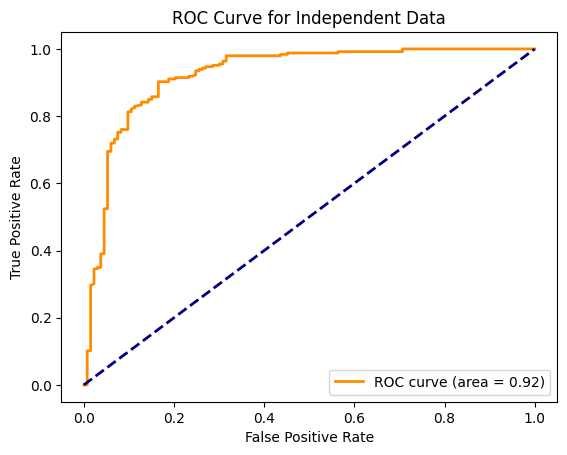

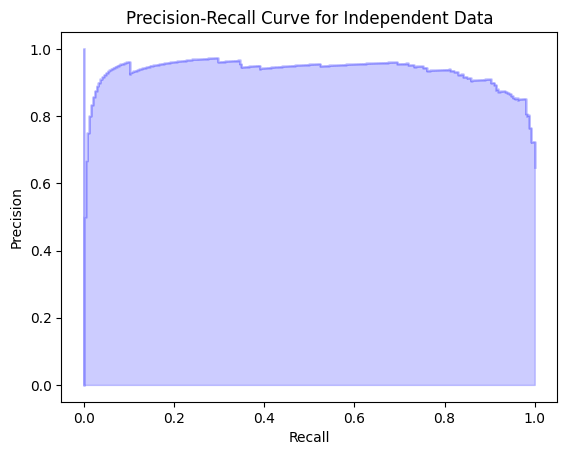

In [10]:
from keras.models import load_model
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, roc_curve, auc, average_precision_score, precision_recall_curve, f1_score, accuracy_score
import numpy as np
import pandas as pd
import math

path = "/content/drive/MyDrive/watshara_data/"
data_ = pd.read_csv(path + 'Dts_AEDN1000.csv')
data = data_.iloc[:, :-1].values
labels = data_.iloc[:, -1].values
y = labels
Xt = scale(data)
yt = labels


# Load the best model from one of the folds (e.g., fold 10)
model_path = path + 'GAN/GAN_fold_10.h5'
clf = load_model(model_path)


# Predict the labels for the independent dataset
y_score = clf.predict(Xt)
y_class = np.argmax(y_score, axis=1)

# Calculate metrics
accuracy = accuracy_score(yt, y_class)
f1 = f1_score(yt, y_class)
TP, FP, FN, TN = confusion_matrix(yt, y_class).ravel()
Sn = TP / (TP + FN)
Sp = TN / (TN + FP)
MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
BACC = 0.5 * TP / (TP + FN) + 0.5 * TN / (TN + FP)
fpr, tpr, _ = roc_curve(yt, y_score[:, 1])
auc_roc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(yt, y_score[:, 1])
average_precision = average_precision_score(yt, y_score[:, 1])

# Print the results
print(f"Accuracy: {round(accuracy, 3)}")
print(f"BACC: {round(BACC, 3)}")
print(f"Sn: {round(Sn, 3)}")
print(f"Sp: {round(Sp, 3)}")
print(f"MCC: {round(MCC, 3)}")
print(f"AUC: {round(auc_roc, 3)}")
print(f"AP: {round(average_precision, 3)}")
print(f"F1: {round(f1, 3)}")

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Independent Data')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, where='post', color='b', alpha=0.2, lw=lw)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Independent Data')
plt.show()


In [ ]:
import os
import statistics
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, roc_curve, auc, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math


optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Discriminator
D = Sequential()
D.add(Dense(64, input_dim=input_dimwx))
D.add(LeakyReLU(alpha=0.2))
D.add(Dropout(0.3))
D.add(Dense(32))
D.add(LeakyReLU(alpha=0.2))
D.add(Dense(out_dim, activation='sigmoid'))
img = Input(shape=(input_dimwx,))
validity = D(img)
Discriminator = Model(img, validity)
Discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

# Generator
G = Sequential()
G.add(Dense(64, input_dim=input_dimwx))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(64))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(32))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(input_dimwx, activation='tanh'))
noise = Input(shape=(input_dimwx,))
G_img = G(noise)
Generator = Model(noise, G_img)

z = Input(shape=(input_dimwx,))
G_img = Generator(z)
Discriminator.trainable = False
validity = Discriminator(G_img)
GAN = Model(z, validity)
GAN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

interp_tpr_collection = []

def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)

def to_categorical(y, nb_classes=None):
    y = np.array(y, dtype='int')
    if not nb_classes:
        nb_classes = np.max(y) + 1
    Y = np.zeros((len(y), nb_classes))
    for i in range(len(y)):
        Y[i, y[i]] = 1
    return Y


# Independent dataset
data_ = pd.read_csv(path + 'Dts_AEDN1000.csv')
data = data_.iloc[:, :-1].values
labels = data_.iloc[:, -1].values
y = labels
Xt = scale(data)
yt = labels

# Initialize metric collections for independent data
BACC_ind = []
Sn_ind = []
Sp_ind = []
MCC_ind = []
AUC_ind = []
AP_ind = []

mean_recall_ind = np.linspace(0, 1, 100)
all_precision_ind = []
mean_tpr_ind = 0.0

interp_tpr_ind_collection = []

# Evaluate on independent dataset
for fold_num in range(1, 11):
    model_path = f'GAN_fold_{fold_num}.h5'

    clf = GAN
    clf.load_weights(model_path)

    y_score = clf.predict(Xt)
    y_class = categorical_probas_to_classes(y_score)

    TP, FP, FN, TN = confusion_matrix(yt, y_class).ravel()
    Sn_ind.append(TP / (TP + FN))
    Sp_ind.append(TN / (TN + FP))
    MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    MCC_ind.append(MCC)
    BACC_ind.append(0.5 * TP / (TP + FN) + 0.5 * TN / (TN + FP))

    fpr, tpr, _ = roc_curve(yt, y_score[:, 1])
    interp_tpr = np.interp(base_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tpr_ind_collection.append(interp_tpr)
    auc_roc = auc(fpr, tpr)
    AUC_ind.append(auc_roc)

    precision, recall, _ = precision_recall_curve(yt, y_score[:, 1])
    average_precision = average_precision_score(yt, y_score[:, 1])
    recall = np.flipud(recall)
    precision = np.flipud(precision)
    mean_precision = np.interp(mean_recall_ind, recall, precision)
    all_precision_ind.append(mean_precision)
    AP_ind.append(average_precision)

print(f"BACC (independent): {round(statistics.mean(BACC_ind), 3)} ± {round(statistics.stdev(BACC_ind), 3)}")
print(f"Sn (independent): {round(statistics.mean(Sn_ind), 3)} ± {round(statistics.stdev(Sn_ind), 3)}")
print(f"Sp (independent): {round(statistics.mean(Sp_ind), 3)} ± {round(statistics.stdev(Sp_ind), 3)}")
print(f"MCC (independent): {round(statistics.mean(MCC_ind), 3)} ± {round(statistics.stdev(MCC_ind), 3)}")
print(f"AUC (independent): {round(statistics.mean(AUC_ind), 3)} ± {round(statistics.stdev(AUC_ind), 3)}")
print(f"AP (independent): {round(statistics.mean(AP_ind), 3)} ± {round(statistics.stdev(AP_ind), 3)}")

mean_tpr_ind = np.mean(interp_tpr_ind_collection, axis=0)
mean_tpr_ind[-1] = 1.0

mean_precision_ind = np.mean(all_precision_ind, axis=0)

np.savez(r'Draw graphics\ROC curve\GAN_PCA_Independent.npz', fpr=base_fpr, tpr=mean_tpr_ind, roc_auc=AUC_ind)
np.savez(r'Draw graphics\PR curve\GAN_PCA_Independent.npz', recall=mean_recall_ind, precision=mean_precision_ind, average_precision=AP_ind)

plt.figure()
lw = 2
plt.plot(base_fpr, mean_tpr_ind, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % np.mean(AUC_ind))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Independent Data')
plt.legend(loc="lower right")
plt.show()

In [5]:

import statistics
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from keras.layers import Input, Dense
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
# from keras.optimizers import adam_v2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from keras.optimizers import Adam
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

# X_train_whole, X_ind_test, y_train_whole, y_ind_test = train_test_split(X_new, y_new, test_size=0.2, random_state=1111)

path = "/content/drive/MyDrive/watshara_data/"
data_ = pd.read_csv(path + 'Dtr_AEDN1000.csv')
data = data_.iloc[:, :-1].values
labels = data_.iloc[:, -1].values
y = labels

# X = np.reshape(X, (-1, 1, n1))
X = scale(data)

# X_train_whole = scale(X_train_whole)
[sample_num, input_dimwx]=np.shape(X)
# X = X_train_whole
# y = y_train_whole
out_dim=2

optimizer = Adam(0.5)
n_y_value = 2

D = Sequential()
D.add(Dense(64))
D.add(LeakyReLU(alpha=0.2))
D.add(Dense(32))
D.add(Dense(2, activation='sigmoid'))
img = Input(shape=(n_y_value,))
validity = D(img)
Discriminator = Model(img,validity)
Discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['binary_accuracy'])



N_ideas = input_dimwx
G = Sequential()
G.add(Dense(64,input_dim=N_ideas))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(64))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(32))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(n_y_value, activation='tanh'))
noise = Input(shape=(N_ideas,))
G_img = G(noise)
Generator = Model(noise,G_img)

z = Input(shape=(N_ideas,))
G_img = Generator(z)
Discriminator.trainable = False
validity = Discriminator(G_img)
GAN = Model(z,validity)
GAN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics =['binary_accuracy'])

BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
AUC_collecton = []
AP=[]

mean_recall = np.linspace(0, 1, 100)
all_precision = []
base_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0

interp_tpr_collection = []


def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)


def to_categorical(y, nb_classes=None):
    y = np.array(y, dtype='int')
    if not nb_classes:
        nb_classes = np.max(y)+1
    Y = np.zeros((len(y), nb_classes))
    for i in range(len(y)):
        Y[i, y[i]] = 1
    return Y

skf = StratifiedKFold(n_splits=10)
for train, test in skf.split(X, y):
    X_train, X_valid, y_train, y_valid = np.take(X, train.tolist(), axis=0), np.take(X, test.tolist(), axis=0), np.take(y, train.tolist(), axis=0), np.take(y, test.tolist(), axis=0)

    y_train = to_categorical(y_train)

    clf = GAN
    hist = clf.fit(X_train, y_train, batch_size=64, epochs=60)
    y_score = clf.predict(X_valid)
    y_class = categorical_probas_to_classes(y_score)
    TP, FP, FN, TN = confusion_matrix(y_valid, y_class).ravel() # shape [ [True-Positive, False-positive], [False-negative, True-negative] ]
    Sn_collecton.append(TP/(TP+FN))
    Sp_collecton.append(TN/(TN+FP))
    MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))
    # ROC curve
    fpr, tpr, _ = roc_curve(y_valid, y_score[:, 1])
    interp_tpr = np.interp(base_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tpr_collection.append(interp_tpr)
    auc_roc = auc(fpr, tpr)
    AUC_collecton.append(auc_roc)
    # PR curve
    precision, recall, _ = precision_recall_curve(y_valid, y_score[:, 1])
    average_precision = average_precision_score(y_valid, y_score[:, 1])
    recall = np.flipud(recall)
    precision = np.flipud(precision)

    mean_precision = np.interp(mean_recall, recall, precision)
    all_precision.append(mean_precision)
    AP.append(average_precision)

#
print(round(statistics.mean(BACC_collecton),3),'±',round(statistics.stdev(BACC_collecton),3))
print(round(statistics.mean(Sn_collecton),3),'±',round(statistics.stdev(Sn_collecton),3))
print(round(statistics.mean(Sp_collecton),3),'±',round(statistics.stdev(Sp_collecton),3))
print(round(statistics.mean(MCC_collecton),3),'±',round(statistics.stdev(MCC_collecton),3))
print(round(statistics.mean(AUC_collecton),3),'±',round(statistics.stdev(AUC_collecton),3))
print(round(statistics.mean(AP),3),'±',round(statistics.stdev(AP),3))

#
mean_tpr = np.mean(interp_tpr_collection, axis=0)
mean_tpr[-1] = 1.0

# Calculate the mean precision
mean_precision = np.mean(all_precision, axis=0)

#
np.savez(r'Draw graphics\ROC curve\GAN_PCA_All_cross_vaild.npz', fpr=base_fpr, tpr=mean_tpr, roc_auc=AUC_collecton)

#
np.savez(r'Draw graphics\PR curve\GAN_PCA_All_cross_vaild.npz', recall=mean_recall, precision=mean_precision, average_precision=AP)

#
plt.figure()
lw = 2
plt.plot(base_fpr, mean_tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % np.mean(AUC_collecton))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('10 k-fold cross vaild')
plt.legend(loc="lower right")
plt.show()


Epoch 1/60

32/32 [==============================] - 2s 5ms/step - loss: 0.6996 - binary_accuracy: 0.4920

Epoch 2/60

32/32 [==============================] - 0s 4ms/step - loss: 0.6959 - binary_accuracy: 0.5211

Epoch 3/60

32/32 [==============================] - 0s 4ms/step - loss: 0.6872 - binary_accuracy: 0.5407

Epoch 4/60

32/32 [==============================] - 0s 4ms/step - loss: 0.6873 - binary_accuracy: 0.5429

Epoch 5/60

32/32 [==============================] - 0s 5ms/step - loss: 0.6866 - binary_accuracy: 0.5364

Epoch 6/60

32/32 [==============================] - 0s 5ms/step - loss: 0.6907 - binary_accuracy: 0.5198

Epoch 7/60

32/32 [==============================] - 0s 6ms/step - loss: 0.6893 - binary_accuracy: 0.5256

Epoch 8/60

32/32 [==============================] - 0s 5ms/step - loss: 0.6862 - binary_accuracy: 0.5422

Epoch 9/60

32/32 [==============================] - 0s 4ms/step - loss: 0.6893 - binary_accuracy: 0.5291

Epoch 10/60

32/32 [=================

<ipython-input-5-ba6079a558c0>:117: RuntimeWarning: invalid value encountered in scalar divide

  Sp_collecton.append(TN/(TN+FP))

<ipython-input-5-ba6079a558c0>:118: RuntimeWarning: invalid value encountered in divide

  MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)

<ipython-input-5-ba6079a558c0>:120: RuntimeWarning: invalid value encountered in scalar divide

  BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))


32/32 [==============================] - 0s 8ms/step - loss: 0.7112 - binary_accuracy: 0.5000

Epoch 2/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7108 - binary_accuracy: 0.5000

Epoch 3/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7097 - binary_accuracy: 0.5000

Epoch 4/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7098 - binary_accuracy: 0.5000

Epoch 5/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7099 - binary_accuracy: 0.5000

Epoch 6/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7097 - binary_accuracy: 0.5000

Epoch 7/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7095 - binary_accuracy: 0.5000

Epoch 8/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7097 - binary_accuracy: 0.5000

Epoch 9/60

32/32 [==============================] - 0s 6ms/step - loss: 0.7095 - binary_accuracy: 0.5000

Epoch 10/60

32/32 [=============================

<ipython-input-5-ba6079a558c0>:117: RuntimeWarning: invalid value encountered in scalar divide

  Sp_collecton.append(TN/(TN+FP))

<ipython-input-5-ba6079a558c0>:118: RuntimeWarning: invalid value encountered in divide

  MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)

<ipython-input-5-ba6079a558c0>:120: RuntimeWarning: invalid value encountered in scalar divide

  BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))


32/32 [==============================] - 0s 5ms/step - loss: 0.7094 - binary_accuracy: 0.5000

Epoch 2/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7095 - binary_accuracy: 0.5000

Epoch 3/60

32/32 [==============================] - 0s 4ms/step - loss: 0.7096 - binary_accuracy: 0.5000

Epoch 4/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7094 - binary_accuracy: 0.5000

Epoch 5/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7095 - binary_accuracy: 0.5000

Epoch 6/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7094 - binary_accuracy: 0.5000

Epoch 7/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7094 - binary_accuracy: 0.5000

Epoch 8/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7095 - binary_accuracy: 0.5000

Epoch 9/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7095 - binary_accuracy: 0.5000

Epoch 10/60

32/32 [=============================

<ipython-input-5-ba6079a558c0>:117: RuntimeWarning: invalid value encountered in scalar divide

  Sp_collecton.append(TN/(TN+FP))

<ipython-input-5-ba6079a558c0>:118: RuntimeWarning: invalid value encountered in divide

  MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)

<ipython-input-5-ba6079a558c0>:120: RuntimeWarning: invalid value encountered in scalar divide

  BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))


32/32 [==============================] - 0s 5ms/step - loss: 0.7096 - binary_accuracy: 0.5000

Epoch 2/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7097 - binary_accuracy: 0.5000

Epoch 3/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7096 - binary_accuracy: 0.5000

Epoch 4/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7096 - binary_accuracy: 0.5000

Epoch 5/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7097 - binary_accuracy: 0.5000

Epoch 6/60

32/32 [==============================] - 0s 4ms/step - loss: 0.7096 - binary_accuracy: 0.5000

Epoch 7/60

32/32 [==============================] - 0s 6ms/step - loss: 0.7095 - binary_accuracy: 0.5000

Epoch 8/60

32/32 [==============================] - 0s 6ms/step - loss: 0.7092 - binary_accuracy: 0.4992

Epoch 9/60

32/32 [==============================] - 0s 6ms/step - loss: 0.7085 - binary_accuracy: 0.5005

Epoch 10/60

32/32 [=============================

<ipython-input-5-ba6079a558c0>:117: RuntimeWarning: invalid value encountered in scalar divide

  Sp_collecton.append(TN/(TN+FP))

<ipython-input-5-ba6079a558c0>:118: RuntimeWarning: invalid value encountered in divide

  MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)

<ipython-input-5-ba6079a558c0>:120: RuntimeWarning: invalid value encountered in scalar divide

  BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))


32/32 [==============================] - 0s 8ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 2/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 3/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 4/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 5/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 6/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 7/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 8/60

32/32 [==============================] - 0s 9ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 9/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 10/60

32/32 [=============================

<ipython-input-5-ba6079a558c0>:117: RuntimeWarning: invalid value encountered in scalar divide

  Sp_collecton.append(TN/(TN+FP))

<ipython-input-5-ba6079a558c0>:118: RuntimeWarning: invalid value encountered in divide

  MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)

<ipython-input-5-ba6079a558c0>:120: RuntimeWarning: invalid value encountered in scalar divide

  BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))


32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 2/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 3/60

32/32 [==============================] - 0s 4ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 4/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 5/60

32/32 [==============================] - 0s 4ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 6/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 7/60

32/32 [==============================] - 0s 6ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 8/60

32/32 [==============================] - 0s 6ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 9/60

32/32 [==============================] - 0s 4ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 10/60

32/32 [=============================

<ipython-input-5-ba6079a558c0>:117: RuntimeWarning: invalid value encountered in scalar divide

  Sp_collecton.append(TN/(TN+FP))

<ipython-input-5-ba6079a558c0>:118: RuntimeWarning: invalid value encountered in divide

  MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)

<ipython-input-5-ba6079a558c0>:120: RuntimeWarning: invalid value encountered in scalar divide

  BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))


32/32 [==============================] - 0s 6ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 2/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 3/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 4/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 5/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 6/60

32/32 [==============================] - 0s 6ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 7/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 8/60

32/32 [==============================] - 0s 4ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 9/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 10/60

32/32 [=============================

<ipython-input-5-ba6079a558c0>:117: RuntimeWarning: invalid value encountered in scalar divide

  Sp_collecton.append(TN/(TN+FP))

<ipython-input-5-ba6079a558c0>:118: RuntimeWarning: invalid value encountered in divide

  MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)

<ipython-input-5-ba6079a558c0>:120: RuntimeWarning: invalid value encountered in scalar divide

  BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))


32/32 [==============================] - 0s 8ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 2/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 3/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 4/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 5/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 6/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 7/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 8/60

32/32 [==============================] - 0s 6ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 9/60

32/32 [==============================] - 0s 6ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 10/60

32/32 [=============================

<ipython-input-5-ba6079a558c0>:117: RuntimeWarning: invalid value encountered in scalar divide

  Sp_collecton.append(TN/(TN+FP))

<ipython-input-5-ba6079a558c0>:118: RuntimeWarning: invalid value encountered in divide

  MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)

<ipython-input-5-ba6079a558c0>:120: RuntimeWarning: invalid value encountered in scalar divide

  BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))


32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 2/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 3/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 4/60

32/32 [==============================] - 0s 6ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 5/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 6/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 7/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 8/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 9/60

32/32 [==============================] - 0s 5ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 10/60

32/32 [=============================

<ipython-input-5-ba6079a558c0>:117: RuntimeWarning: invalid value encountered in scalar divide

  Sp_collecton.append(TN/(TN+FP))

<ipython-input-5-ba6079a558c0>:118: RuntimeWarning: invalid value encountered in divide

  MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)

<ipython-input-5-ba6079a558c0>:120: RuntimeWarning: invalid value encountered in scalar divide

  BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))


32/32 [==============================] - 0s 7ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 2/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 3/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 4/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 5/60

32/32 [==============================] - 0s 8ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 6/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 7/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 8/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 9/60

32/32 [==============================] - 0s 7ms/step - loss: 0.7086 - binary_accuracy: 0.5000

Epoch 10/60

32/32 [=============================

<ipython-input-5-ba6079a558c0>:117: RuntimeWarning: invalid value encountered in scalar divide

  Sp_collecton.append(TN/(TN+FP))

<ipython-input-5-ba6079a558c0>:118: RuntimeWarning: invalid value encountered in divide

  MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)

<ipython-input-5-ba6079a558c0>:120: RuntimeWarning: invalid value encountered in scalar divide

  BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))


ValueError: cannot convert NaN to integer ratio

Epoch 1/60

13/13 [==============================] - 1s 7ms/step - loss: 0.6945 - binary_accuracy: 0.4645

Epoch 2/60

13/13 [==============================] - 0s 7ms/step - loss: 0.6847 - binary_accuracy: 0.5349

Epoch 3/60

13/13 [==============================] - 0s 8ms/step - loss: 0.6755 - binary_accuracy: 0.5901

Epoch 4/60

13/13 [==============================] - 0s 7ms/step - loss: 0.6706 - binary_accuracy: 0.6170

Epoch 5/60

13/13 [==============================] - 0s 7ms/step - loss: 0.6643 - binary_accuracy: 0.6526

Epoch 6/60

13/13 [==============================] - 0s 7ms/step - loss: 0.6606 - binary_accuracy: 0.6740

Epoch 7/60

13/13 [==============================] - 0s 8ms/step - loss: 0.6560 - binary_accuracy: 0.7071

Epoch 8/60

13/13 [==============================] - 0s 8ms/step - loss: 0.6528 - binary_accuracy: 0.7224

Epoch 9/60

13/13 [==============================] - 0s 8ms/step - loss: 0.6503 - binary_accuracy: 0.7359

Epoch 10/60

13/13 [=================

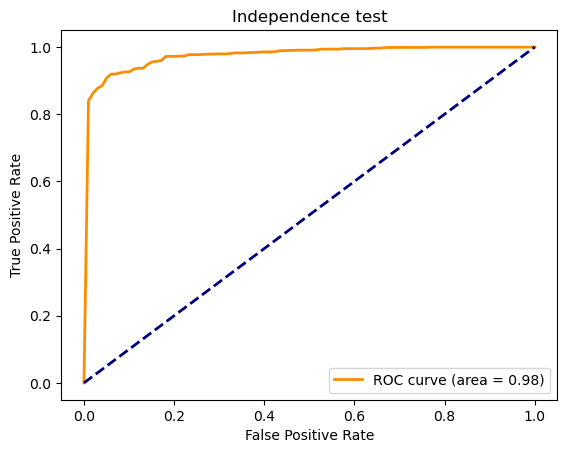

In [ ]:
# 独立测试集
import statistics
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from keras.layers import Input, Dense
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import adam_v2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split


# X_new = scale(X_new)
[sample_num,input_dimwx]=np.shape(X_new)
X = X_new

y = y_new
out_dim=2

optimizer = adam_v2.Adam(0.0002, 0.5)
n_y_value = 2

D = Sequential()
D.add(Dense(64))
D.add(LeakyReLU(alpha=0.2))
D.add(Dense(32))
D.add(Dense(2, activation='sigmoid'))
img = Input(shape=(n_y_value,))
validity = D(img)
Discriminator = Model(img,validity)
Discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['binary_accuracy'])


#####构建生成器，并组合生成器和鉴别器成GAN
N_ideas = input_dimwx
G = Sequential()
G.add(Dense(64,input_dim=N_ideas))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(64))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(32))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(n_y_value, activation='tanh'))
noise = Input(shape=(N_ideas,))
G_img = G(noise)
Generator = Model(noise,G_img)

z = Input(shape=(N_ideas,))
G_img = Generator(z)
Discriminator.trainable = False
validity = Discriminator(G_img)
GAN = Model(z,validity)
GAN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics =['binary_accuracy'])

BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
AUC_collecton = []
AP=[]
mean_recall = np.linspace(0, 1, 100)
all_precision = []

base_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0
# 新的TPR集合
interp_tpr_collection = []


def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)


def to_categorical(y, nb_classes=None):
    y = np.array(y, dtype='int')
    if not nb_classes:
        nb_classes = np.max(y)+1
    Y = np.zeros((len(y), nb_classes))
    for i in range(len(y)):
        Y[i, y[i]] = 1
    return Y

for i in range(10):
    # dataset splitting
    X_train_whole, X_ind_test, y_train_whole, y_ind_test = train_test_split(X, y, test_size=0.2, random_state=i)

    y_train = to_categorical(y_train_whole)

    clf = GAN
    hist = clf.fit(X_train_whole, y_train, batch_size=64, epochs=60)
    y_score = clf.predict(X_ind_test)
    y_class = categorical_probas_to_classes(y_score)
    TP, FP, FN, TN = confusion_matrix(y_ind_test, y_class).ravel() # shape [ [True-Positive, False-positive], [False-negative, True-negative] ]
    Sn_collecton.append(TP/(TP+FN))
    Sp_collecton.append(TN/(TN+FP))
    MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))
    # ROC curve
    fpr, tpr, _ = roc_curve(y_ind_test, y_score[:, 1])
    interp_tpr = np.interp(base_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tpr_collection.append(interp_tpr)
    auc_roc = auc(fpr, tpr)
    AUC_collecton.append(auc_roc)
    # PR curve
    precision, recall, _ = precision_recall_curve(y_ind_test, y_score[:, 1])
    average_precision = average_precision_score(y_ind_test, y_score[:, 1])
    recall = np.flipud(recall)
    precision = np.flipud(precision)

    mean_precision = np.interp(mean_recall, recall, precision)
    all_precision.append(mean_precision)
    AP.append(average_precision)

# 输出结果
print(round(statistics.mean(BACC_collecton),3),'±',round(statistics.stdev(BACC_collecton),3))
print(round(statistics.mean(Sn_collecton),3),'±',round(statistics.stdev(Sn_collecton),3))
print(round(statistics.mean(Sp_collecton),3),'±',round(statistics.stdev(Sp_collecton),3))
print(round(statistics.mean(MCC_collecton),3),'±',round(statistics.stdev(MCC_collecton),3))
print(round(statistics.mean(AUC_collecton),3),'±',round(statistics.stdev(AUC_collecton),3))
print(round(statistics.mean(AP),3),'±',round(statistics.stdev(AP),3))

# 在所有交叉验证循环结束后，计算TPR的均值
mean_tpr = np.mean(interp_tpr_collection, axis=0)
mean_tpr[-1] = 1.0

# Calculate the mean precision
mean_precision = np.mean(all_precision, axis=0)

# 保存ROC曲线相关参数
np.savez(r'Draw graphics\ROC curve\GAN_PCA_All_Indenpendence.npz', fpr=base_fpr, tpr=mean_tpr, roc_auc=AUC_collecton)

# 保存PR曲线相关参数
np.savez(r'Draw graphics\PR curve\GAN_PCA_All_Indenpendence.npz', recall=mean_recall, precision=mean_precision, average_precision=AP)

# 绘制ROC曲线
plt.figure()
lw = 2
plt.plot(base_fpr, mean_tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % np.mean(AUC_collecton))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Independence test')
plt.legend(loc="lower right")
plt.show()